In [2]:
import pandas as pd
import geopandas
import seaborn as sns
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

The FSA map is from Canada Post - it's a set of geometry polygons for each Forward Sortation Area in the country.

In [3]:
FSA_map = geopandas.read_file('FSA_Shapefile')

In [4]:
#Filter down the FSA to only Ontario
FSA_map = FSA_map[FSA_map['PRUID'] == "35"]

Now we get census data at the FSA level - this is a monster file that contains data for every single FSA in the country, so we're going to need to get it down to a manageable size pretty quickly.

In [5]:
Census_data = pd.read_csv('98-401-X2021013_English_CSV_data.csv', encoding='latin-1')

In [6]:
# Filter to only get postal codes that start with M and N - M is general SW Ontario with a few in Toronto, while N is almost entirely in Toronto.
SW_ON_Census_Data = Census_data.loc[Census_data['GEO_NAME'].str.match(r'[MN]\d\w', na=False)]

In [7]:
# Filter to only get the 2021 population characteristic
SW_ON_Census_Data = SW_ON_Census_Data[SW_ON_Census_Data['CHARACTERISTIC_ID'] == 1]

In [8]:
# Only take the two columns we care about
Filtered_SW_ON_Census_Data = SW_ON_Census_Data[['GEO_NAME', 'C1_COUNT_TOTAL']]

In [9]:
Filtered_SW_ON_Census_Data = Filtered_SW_ON_Census_Data.rename(columns={
    'GEO_NAME': 'FSA',
    'C1_COUNT_TOTAL': '2021 Population'
}).set_index('FSA')

Filtered_SW_ON_Census_Data.head()

,2021 Population
FSA,
M1B,65555.0
M1C,35642.0
M1E,48033.0
M1G,30894.0
M1H,23964.0


Look at the distribution - how does it generally look?

<Axes: >

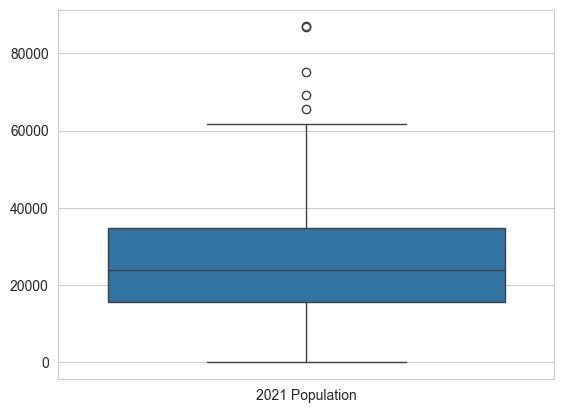

In [10]:
sns.boxplot(Filtered_SW_ON_Census_Data)

<Axes: ylabel='Count'>

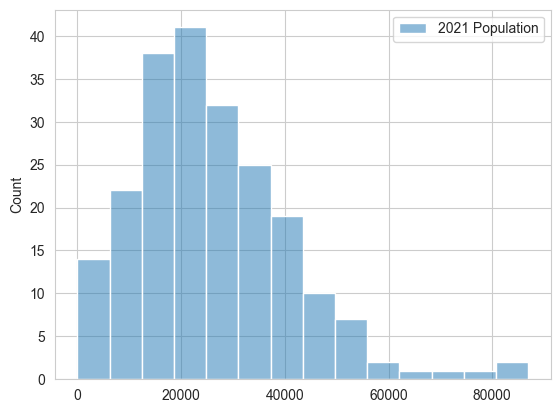

In [11]:
sns.histplot(Filtered_SW_ON_Census_Data, kde=False)

Not bad - definitely some skew, but nothing outrageous.

Now we can make a multiplier per 1,000 population to start normalizing everything else to. The per 1000 is a bit arbitrary, but feels reasonable given the majority of our FSA's are between 18,000-35,000 residents. Per 10,000 would be small and per 100 would be big.

In [12]:
Filtered_SW_ON_Census_Data['Per 1000 Multiplier'] = 1000 / Filtered_SW_ON_Census_Data['2021 Population']

Great - now let's pull in the COVID case data. This comes from the City of Toronto, and has a row for each case that includes the FSA, the date of the case, as well as a few flags for signs of a more serious case such as intubation and hospital or ICU admission.

In [13]:
covid_cases = pd.read_csv('COVID19 cases.csv')

In [14]:
# Get only 2020 cases
covid_cases_2020 = covid_cases[covid_cases['Episode Date'] < '2021-01-01']

In [15]:
# Get the age distribution - both as n and %
age_percentages = (covid_cases_2020.value_counts('Age Group', normalize = True)* 100).round(1)
age_counts = covid_cases_2020.value_counts('Age Group')

In [16]:
Age_table = pd.merge(left = age_percentages, right = age_counts, on = 'Age Group').sort_values('Age Group')

In [17]:
# This is the data for Table 1
Age_table

,proportion,count
Age Group,,
19 and younger,12.1,8093
20 to 29 Years,19.9,13318
30 to 39 Years,16.5,11082
40 to 49 Years,14.2,9488
50 to 59 Years,14.7,9876
60 to 69 Years,9.4,6323
70 to 79 Years,5.0,3320
80 to 89 Years,5.0,3325
90 and older,3.2,2177


In [18]:
# get the gender distribution - both as n and %
percentages = covid_cases_2020.value_counts('Client Gender', normalize = True)
counts = covid_cases_2020.value_counts('Client Gender')

In [19]:
Gender_Table = pd.merge(left = percentages, right = counts, on = 'Client Gender')

In [20]:
Gender_Table['%'] = (Gender_Table['proportion'] * 100).round(1)

In [21]:
Gender_Table.drop('proportion', axis = 1, inplace = True)

In [22]:
# This is the data for Table 1
Gender_Table

,count,%
Client Gender,,
FEMALE,34198,51.0
MALE,32585,48.6
UNKNOWN,234,0.3
OTHER,12,0.0
TRANSGENDER,9,0.0
NON-BINARY,1,0.0
TRANS WOMAN,1,0.0


In [23]:
# Do a bit of data wrangling - get the date column to be a date, and turn yes/no columns into 1/0 columns for later.

covid_cases['Episode Date'] = pd.to_datetime(covid_cases['Episode Date'])
cols_to_convert = ['Ever Hospitalized', 'Ever in ICU', 'Ever Intubated']
for col in cols_to_convert:
    covid_cases[col] = covid_cases[col].map({'Yes': 1, 'No': 0})

Looking at the distribution of the data now

In [24]:
# Group all the covid cases by their FSA
FSA_Cases = covid_cases['FSA'].value_counts().to_frame()

<Axes: ylabel='Count'>

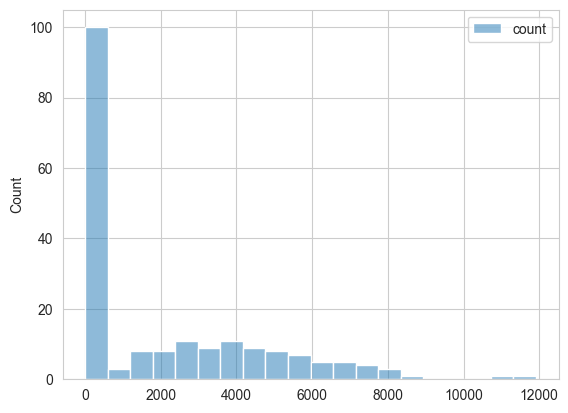

In [25]:
sns.histplot(FSA_Cases, bins=20)

Well that's...interesting - going in and looking at the data itself, there's a whole bunch of FSA with only a single case, and some hand checking reveals that they aren't real FSA's!

Lets see what FSA's in there don't appear in the official list

In [26]:
funky_FSA_codes = FSA_Cases[~FSA_Cases.index.isin(FSA_map['CFSAUID'])]

In [27]:
funky_FSA_codes

,count
FSA,
M6V,41
M8B,21
M3E,16
M9E,15
M3R,14
...,...
M0P,1
M7L,1
M8J,1


Looking at these, they're all unassigned by Canada Post, meaning they're not valid. I'm guessing these are a data entry problem into the dataset.

In [28]:
funky_FSA_codes['count'].sum()

np.int64(448)

Given that these funky (erroneous) FSA's are such a small group out of the whole number of cases, I'm just going to get rid of them.

In [29]:
# Drop any cases where the FSA for the case isn't in the Canada Post list
Real_FSA_Cases = FSA_Cases[FSA_Cases.index.isin(FSA_map['CFSAUID'])]

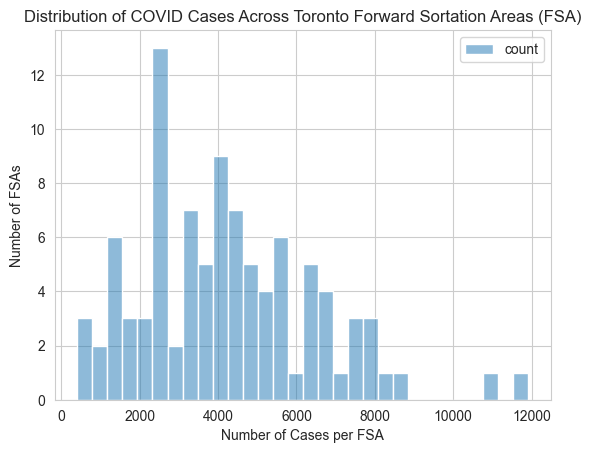

In [30]:
sns.histplot(Real_FSA_Cases, bins=30)
plt.xlabel('Number of Cases per FSA')
plt.ylabel('Number of FSAs')
plt.title('Distribution of COVID Cases Across Toronto Forward Sortation Areas (FSA)')
plt.show()

That's a better distribution - now let's adjust per 1000 and see what that gets us.

In [35]:
#  Go get a series with just the FSA as index and the multiplier I calculated earlier
multiplier = Filtered_SW_ON_Census_Data['Per 1000 Multiplier']

In [36]:
Real_FSA_Cases = Real_FSA_Cases.merge(
    multiplier,
    left_index=True,           # Use FSA index from Real_FSA_Cases
    right_on='FSA',           # Match with FSA column in multiplier
    how='left'                # Keep all rows from Real_FSA_Cases
)

In [37]:
# Multiply the FSA level case counts by the population multiplier
Real_FSA_Cases['Covid Cases per 1000'] = Real_FSA_Cases['count'] * Real_FSA_Cases['Per 1000 Multiplier']

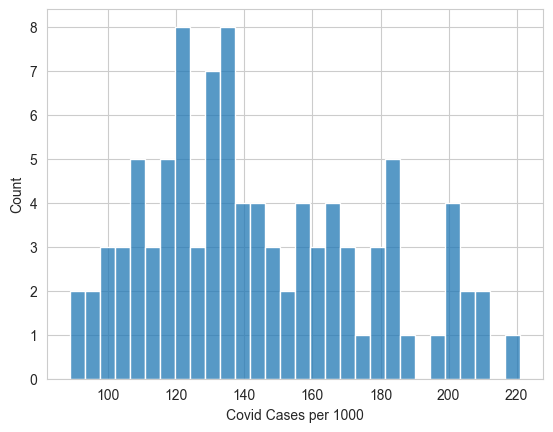

In [38]:
sns.histplot(data = Real_FSA_Cases, x = 'Covid Cases per 1000', bins=30)
plt.show()

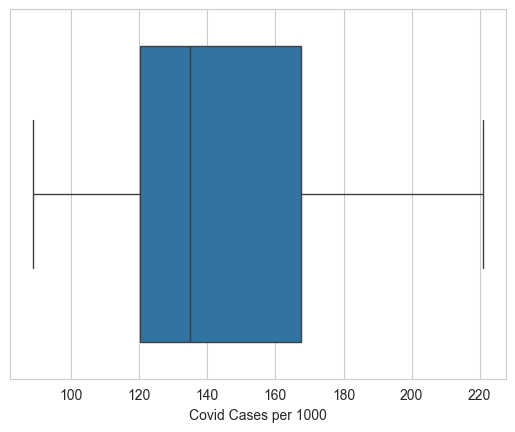

In [39]:
sns.boxplot(data = Real_FSA_Cases, x = 'Covid Cases per 1000')
plt.show()

Better looking - Not a normal distribution by any means, but definitely more tighly clustered.

In [40]:
# Drop the non-real FSA's the same way we did on the area sums

covid_cases = covid_cases[covid_cases['FSA'].isin(FSA_map['CFSAUID'])]

In [41]:
covid_cases.shape

# This is how many cases were included for analysis

(406154, 15)

In [42]:
#Group the cases weekly by FSA - we're doing it off the episode date column

covid_weekly_cases = covid_cases.groupby([
    pd.Grouper(key = 'Episode Date', freq = 'W'),
    'FSA'
]).agg({
      'Ever Hospitalized': 'sum', # these sums work because previously we converted it to 1/0 for T/F
    'Ever in ICU': 'sum',
    'Ever Intubated': 'sum',
    '_id': 'nunique' # _id is the unique case id - there's no patient level identifier, so there's a possibility the same person with different
})

In [43]:
covid_weekly_cases.rename({'_id': 'Weekly Cases'}, axis=1, inplace=True)

In [44]:
# Normalize each column by multiplying the individual value by it's population multiplier

columns_to_normalize = ['Weekly Cases', 'Ever Hospitalized', 'Ever in ICU', 'Ever Intubated']

for col in columns_to_normalize:
    new_col_name = f'{col} per 1000'
    covid_weekly_cases.loc[:, new_col_name] = covid_weekly_cases[col] * covid_weekly_cases.index.get_level_values('FSA').map(multiplier)

In [45]:
covid_weekly_cases.head()

Ever Hospitalized  Ever in ICU  Ever Intubated  \
Episode Date FSA                                                   
2020-01-26   M2N                  1            0               0   
             M5G                  0            0               0   
2020-02-02   M2L                  0            0               0   
             M6M                  0            0               0   
2020-02-09   M3A                  0            0               0   

                  Weekly Cases  Weekly Cases per 1000  \
Episode Date FSA                                        
2020-01-26   M2N             2               0.026631   
             M5G             1               0.102554   
2020-02-02   M2L             1               0.088700   
             M6M             1               0.023726   
2020-02-09   M3A             1               0.029103   

                  Ever Hospitalized per 1000  Ever in ICU per 1000  \
Episode Date FSA                                                     
2020-01-26   M2N                    0.013316                   0.0   
             M5G                    0.000000                   0.0   
2020-02-02   M2L                    0.000000                   0.0   
             M6M                    0.000000                   0.0   
2020-02-09   M3A                    0.000000                   0.0   

                  Ever Intubated per 1000  
Episode Date FSA                           
2020-01-26   M2N                      0.0  
             M5G                      0.0  
2020-02-02   M2L                      0.0  
             M6M                      0.0  
2020-02-09   M3A                      0.0

Okay, now getting the EMS calls - these are published by Toronto Paramedic Services, and give data on the FSA, the dispatch triage priority, as well as a few other pieces. It comes in a big spreadsheet, so we're only going to pull the tab for 2020

In [46]:
EMS_calls = pd.read_excel('paramedic-services-incident-data-2017-2022.xlsx', sheet_name='2020')


In [47]:
EMS_calls.head()

,ID,Dispatch_Time,Incident_Type,Priority_Number,Units_Arrived_At_Scene,Forward_Sortation_Area
0,6659063,2020-03-16 17:04:01,Fire,1,14,M9W
1,6637804,2020-02-26 17:12:36,Medical,1,11,M5B
2,6829985,2020-09-02 02:04:06,Medical,1,10,M6E
3,6726730,2020-05-26 16:09:41,Medical,1,9,M5V
4,6761768,2020-06-30 05:02:40,Fire,3,9,M3J


In [48]:
EMS_calls.shape

(270600, 6)

In [49]:
# The data is provided with '-' for blank values; see how many there are.

EMS_calls.Forward_Sortation_Area.value_counts().get('-')

np.int64(70)

In [50]:
# For 70 calls out of 270,000, I'm comfortable dropping them. Especially since I don't have any way to match them.

EMS_calls = EMS_calls[EMS_calls.Forward_Sortation_Area != '-']

Toronto uses some synthetic priority codes, according to the readme from the dataset:

| Priority | Description |
|----------|-------------|
| 1        | Delta       |
| 3        | Charlie     |
| 4        | Bravo       |
| 5        | Alpha       |
| 9        | Echo        |
| 11       | Alpha1      |
| 12       | Alpha2      |
| 13       | Alpha3      |
| 14       | Code 2      |

I'll map these to a smaller list of readable values, then get dummy variables to go along with them. Also taking out Code 2, since it's for scheduled transfers.



In [51]:
Priority_name_map = {
    9: 'Resuscitation',
    1: 'High',
    3: 'High',
    4: 'Low',
    5: 'Low',
    11: 'Low',
    12: 'Low',
    13: 'Low'
}

EMS_calls['Priority_Name'] = EMS_calls['Priority_Number'].map(Priority_name_map)

In [52]:
# Get dummy variables for my new calculated acuities

EMS_calls = pd.get_dummies(EMS_calls, columns = ['Priority_Name'])

In [53]:
# How are the Incident Types broken down?
EMS_calls['Incident_Type'].value_counts()

Incident_Type
Medical                   254166
Motor Vehicle Accident      8390
Emergency Transfer          6572
Fire                         782
-                            613
Airport Standby                7
Name: count, dtype: int64

In [119]:
# Look at unit counts - we don't want to count a call that the paramedics never made it to, and we should also exclude MCI's where you have 4 ambulances since that's not going to be COVID.

EMS_calls[~EMS_calls['Units_Arrived_At_Scene'].between(1, 3, inclusive='both')].shape

(537, 9)

In [54]:
#Considering the majority of calls are non-MCI's and are Medical call types, I'm going to remove any events that don't meet those criteria.

Filtered_EMS_calls = EMS_calls[
    (EMS_calls['Incident_Type'] == 'Medical') &
    (EMS_calls['Units_Arrived_At_Scene'].between(1, 3, inclusive='both'))
]

In [55]:
Filtered_EMS_calls = Filtered_EMS_calls.rename(columns = {'Forward_Sortation_Area': 'FSA'})

In [56]:
Filtered_EMS_calls.shape

# This is the number of EMS calls included in the analysis

(253936, 9)

In [57]:
# get a DF that's an aggregate of the EMS calls by FSA (no weekly grouping yet)
FSA_Calls = Filtered_EMS_calls['FSA'].value_counts().to_frame()

<Axes: xlabel='count'>

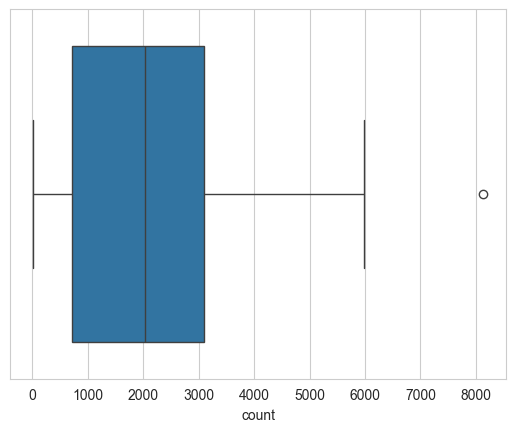

In [58]:
sns.boxplot(data = FSA_Calls, x = 'count')

<Axes: ylabel='Count'>

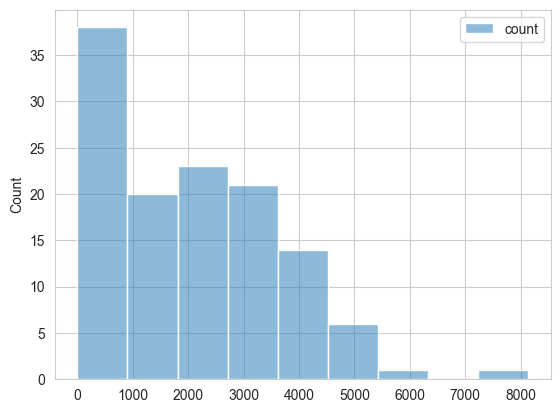

In [59]:
sns.histplot(data = FSA_Calls)

Well - that's a right skew for sure, let's normalize and see what we get

In [60]:
FSA_Calls.loc[:, 'EMS per 1000'] = FSA_Calls['count'] * FSA_Calls.index.map(multiplier)

<Axes: xlabel='EMS per 1000'>

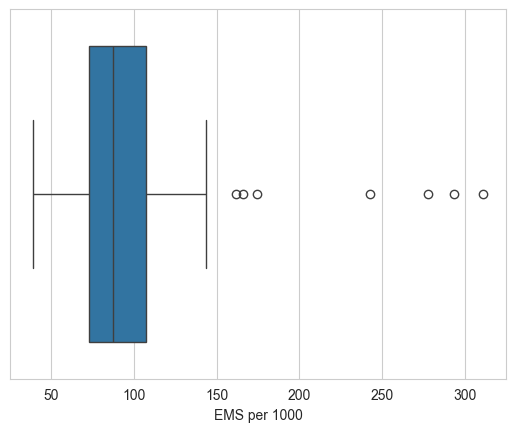

In [61]:
sns.boxplot(data = FSA_Calls, x = 'EMS per 1000')

Well that's better - a better distribution, though there's more outliers

In [62]:
#Group the EMS calls weekly by FSA - we're doing it off the date in the dispatch time column'

EMS_weekly_cases = Filtered_EMS_calls.groupby([
    pd.Grouper(key='Dispatch_Time', freq='W'),
    'FSA'
]).agg({
    'ID': 'nunique',
    'Priority_Name_High' : 'sum',
    'Priority_Name_Low' : 'sum',
    'Priority_Name_Resuscitation' : 'sum'
}).reset_index()

In [63]:
covid_weekly_cases = covid_weekly_cases.rename({'Episode Date':'Week Start'},axis = 1)
EMS_weekly_cases = EMS_weekly_cases.rename({'Dispatch_Time':'Week Start', 'ID': 'EMS Calls'},axis = 1)

In [64]:
# Normalize each row by multiplying the individual value by it's population multiplier

EMS_weekly_cases.loc[:, 'Weekly EMS Calls per 1000'] = EMS_weekly_cases['EMS Calls'] * EMS_weekly_cases['FSA'].map(multiplier)

In [65]:
# Calculate the proportion of calls that are either high priority or resuscitation

EMS_weekly_cases.loc[:, '% of calls are High Acuity'] = (EMS_weekly_cases['Priority_Name_High'] + EMS_weekly_cases['Priority_Name_Resuscitation']) / EMS_weekly_cases['EMS Calls']

In [66]:
#Attach a geometry to each of week and FSA

EMS_weekly_cases = EMS_weekly_cases.merge(FSA_map, left_on = 'FSA', right_on = 'CFSAUID', how = 'left')

In [67]:
# Convert this into a GeoDataFrame

gdf_EMS_weekly_cases = geopandas.GeoDataFrame(EMS_weekly_cases, geometry = 'geometry')

In [120]:
gdf_EMS_weekly_cases

,Week Start,FSA,EMS Calls,Priority_Name_High,Priority_Name_Low,Priority_Name_Resuscitation,Weekly EMS Calls per 1000,% of calls are High Acuity,CFSAUID,DGUID,PRUID,PRNAME,LANDAREA,geometry
0,2020-01-05,L1V,3,2,1,0,NaN,0.666667,L1V,2021A0011L1V,35,Ontario,17.7631,"POLYGON ((7246325.651 955539.731, 7246482.809 ..."
1,2020-01-05,L1W,1,1,0,0,NaN,1.000000,L1W,2021A0011L1W,35,Ontario,16.7570,"POLYGON ((7247441.143 955283.674, 7247698.351 ..."
2,2020-01-05,L3R,1,1,0,0,NaN,1.000000,L3R,2021A0011L3R,35,Ontario,19.4291,"MULTIPOLYGON (((7226826.14 950396.72, 7226822...."
3,2020-01-05,L3S,5,3,2,0,NaN,0.600000,L3S,2021A0011L3S,35,Ontario,15.3115,"POLYGON ((7232899.171 953407.851, 7232941.191 ..."
4,2020-01-05,L3T,1,1,0,0,NaN,1.000000,L3T,2021A0011L3T,35,Ontario,24.2116,"POLYGON ((7223067.531 949578.194, 7223095.606 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5631,2021-01-03,M9N,30,14,15,1,1.151234,0.500000,M9N,2021A0011M9N,35,Ontario,5.1476,"POLYGON ((7213743.029 932811.197, 7213751.666 ..."
5632,2021-01-03,M9P,27,18,8,1,1.307823,0.703704,M9P,2021A0011M9P,35,Ontario,6.7153,"POLYGON ((7211052.757 932400.003, 7211109.709 ..."
5633,2021-01-03,M9R,37,24,11,2,1.095225,0.702703,M9R,2021A0011M9R,35,Ontario,6.5681,"POLYGON ((7209541.409 930754.371, 7209590.637 ..."
5634,2021-01-03,M9V,59,34,24,1,1.095067,0.593220,M9V,2021A0011M9V,35,Ontario,15.5433,"POLYGON ((7206677.477 937734.717, 7206659.534 ..."


Now there's a stack of NaN in the new calls per 100 column - wonder if all the calls are actually in Toronto to get a number from?

<Axes: >

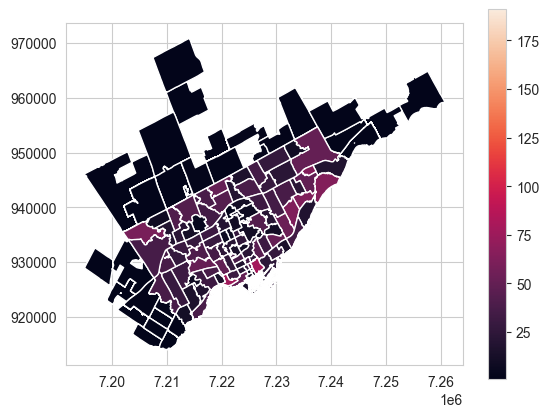

In [68]:
gdf_EMS_weekly_cases.plot(column = 'EMS Calls', legend = True)

Aha - calls are also included from outside Toronto when the EMS crews do mutual aid. I can just drop columns where there wasn't a value since those are areas without pop data for Toronto itself.

In [69]:
EMS_weekly_cases = EMS_weekly_cases[EMS_weekly_cases['Weekly EMS Calls per 1000'].notna()]

In [70]:
# Make one DF with COVID cases and EMS calls

weekly_data = covid_weekly_cases.merge(EMS_weekly_cases, left_index = True, right_on =['Week Start', 'FSA'] )

In [71]:
# Multi level index

weekly_data = weekly_data.set_index(['Week Start', 'FSA'])

<Axes: xlabel='Weekly Cases per 1000', ylabel='Weekly EMS Calls per 1000'>

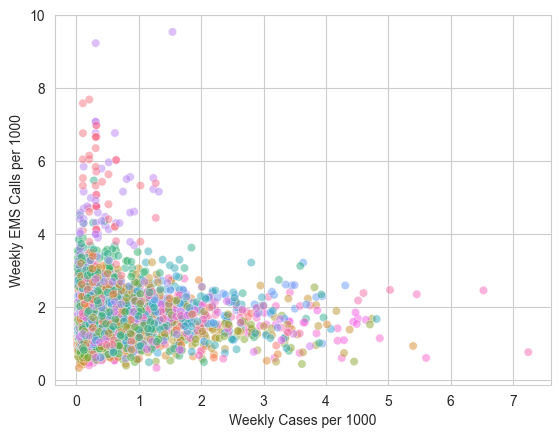

In [72]:
sns.scatterplot(weekly_data, x = 'Weekly Cases per 1000', y = 'Weekly EMS Calls per 1000', hue = 'FSA', legend = None, alpha = 0.5)

We can see the baseline EMS volume, and an interesting pattern where certain FSA's appear to have a high base volume but relatively consistently low case volume.

<Axes: xlabel='Week Start'>

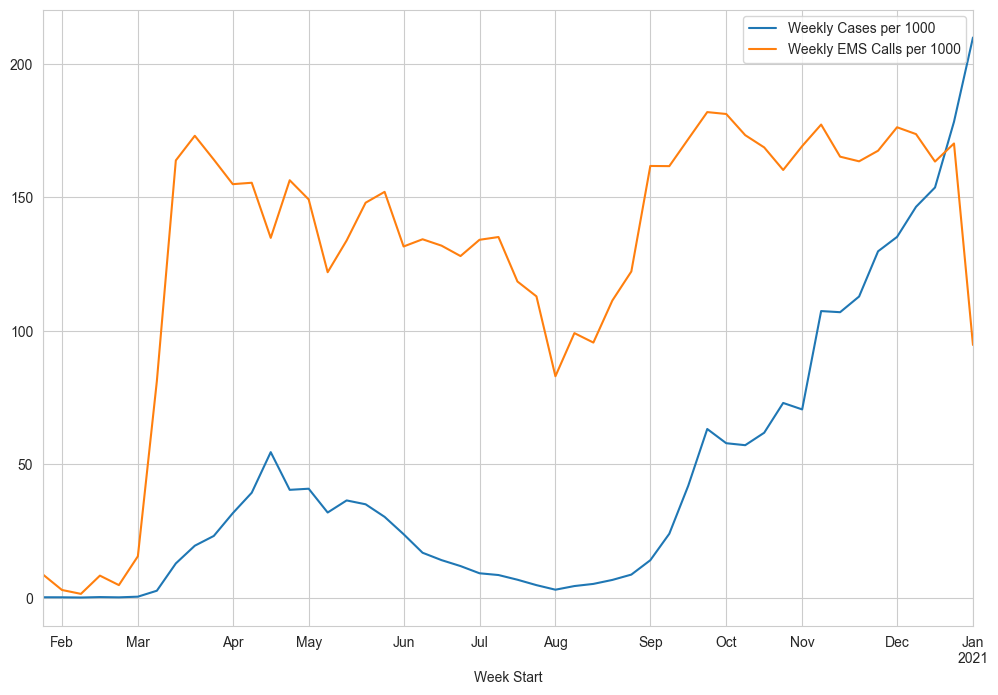

In [73]:
#Graph weekly cases and ems calls at the city-wide level

weekly_data.reset_index().groupby('Week Start').agg({
    'Weekly Cases per 1000': 'sum',
    'Weekly EMS Calls per 1000': 'sum'
}).plot(subplots=False, figsize=(12,8))

That looks like there might be something there - The macro patterns seem to be moving roughly together at least through November.

In [121]:
# Function to calculate weekly correlation between cases and EMS calls

def calculate_weekly_stats(group):
    cases = group['Weekly Cases per 1000']
    ems_calls = group['Weekly EMS Calls per 1000']

    if len(cases) < 3: # Make sure there's enough data to calculate a correlation
        return pd.Series({'correlation': np.nan, 'p_value': np.nan})

    corr, p_val = pearsonr(cases, ems_calls)
    return pd.Series({'correlation': corr, 'p_value': p_val})

weekly_stats = weekly_data.groupby('Week Start').apply(calculate_weekly_stats) # Run the function over the data

weekly_stats.sort_values(by = 'p_value', ascending = True, inplace = True) # Sort the result by ascending p-value to see significant values first

weekly_stats # See the result

,correlation,p_value
Week Start,,
2020-03-15,0.607724,2.260928e-09
2020-09-13,0.483714,1.190443e-06
2020-03-22,0.403910,5.945873e-05
2020-02-16,0.999426,5.740105e-04
2020-09-20,0.325189,1.470153e-03
2020-09-27,0.271687,7.413471e-03
2020-05-03,0.271670,9.592738e-03
2020-04-19,0.272640,1.017279e-02
2020-07-19,0.271489,3.280419e-02


This is the "answer" - there's 7 weeks where the correlation value is significant (< 0.05) , and of those weeks only 2 actually show a correlation value that suggests there is a correlation (> 0.5 or < -0.5). Interestingly, the significant weeks all appear to be in February, March, April and September. Lets look at doing a lag in either direction to see if there's a lag relationship.

In [77]:
# Add a column for a shift in each direction. Keep EMS calls static and shift case counts
weekly_data['Weekly Cases per 1000 Lag +1'] = weekly_data['Weekly Cases per 1000'].shift(1)
weekly_data['Weekly Cases per 1000 Lag -1'] = weekly_data['Weekly Cases per 1000'].shift(-1)

In [122]:
def calculate_weekly_stats_plus_one(group):
    cases = group['Weekly Cases per 1000 Lag +1']
    ems_calls = group['Weekly EMS Calls per 1000']

    if len(cases) < 3:
        return pd.Series({'correlation': np.nan, 'p_value': np.nan})

    corr, p_val = pearsonr(cases, ems_calls)
    return pd.Series({'correlation': corr, 'p_value': p_val})

weekly_stats_plus_one = weekly_data.groupby('Week Start').apply(calculate_weekly_stats_plus_one) # run the function over the data

weekly_stats_plus_one.sort_values(by = 'p_value', ascending = True, inplace = True) # sort the result by ascending p-value to see significant values first

weekly_stats_plus_one # get the result

,correlation,p_value
Week Start,,
2020-03-22,0.259238,0.012099
2020-09-13,0.212234,0.043418
2020-09-27,0.170444,0.096854
2020-09-20,0.157569,0.131445
2020-03-15,0.168763,0.134534
2020-06-28,-0.169687,0.151225
2020-12-13,-0.133154,0.195901
2020-03-08,-0.194424,0.205999
2020-11-22,-0.128072,0.216138


In [149]:
def calculate_weekly_stats_minus_one(group):
    cases = group['Weekly Cases per 1000 Lag -1']
    ems_calls = group['Weekly EMS Calls per 1000']

    if len(cases) < 3:
        return pd.Series({'correlation': np.nan, 'p_value': np.nan})

    corr, p_val = pearsonr(cases, ems_calls)
    return pd.Series({'correlation': corr, 'p_value': p_val})

weekly_stats_minus_one = weekly_data.groupby('Week Start').apply(calculate_weekly_stats_minus_one) # run the function over the data

weekly_stats_minus_one.sort_values(by = 'p_value', ascending = True, inplace = True) # sort the result by ascending p-value to see significant values first

weekly_stats_minus_one # get the result

,correlation,p_value
Week Start,,
2020-03-15,0.479315,0.000007
2020-09-20,0.248363,0.016374
2020-09-13,0.226201,0.031082
2020-11-22,-0.202560,0.048996
2020-12-13,-0.190701,0.062727
2020-09-06,0.203141,0.072566
2020-11-01,-0.176458,0.088884
2020-12-27,-0.174442,0.090889
2020-09-27,0.150554,0.143150


Not much there and any weeks with a significant p value are all correlation < 0.5 which is generally too weak to mean much.

Let's look quickly at the FSA's and see if there's anything there.

In [125]:
def calculate_fsa_correlation_and_pvalue(group):
    cases = group['Weekly Cases per 1000']
    ems_calls = group['Weekly EMS Calls per 1000']

    # Need at least 3 weeks of data for meaningful correlation
    if len(cases) < 3:
        return pd.Series({'correlation': np.nan, 'p_value': np.nan, 'n_weeks': len(cases)})

    corr, p_val = pearsonr(cases, ems_calls)
    return pd.Series({'correlation': corr, 'p_value': p_val, 'n_weeks': len(cases)})

fsa_stats = weekly_data.groupby('FSA').apply(calculate_fsa_correlation_and_pvalue)

fsa_stats.sort_values(by = 'p_value', ascending = True, inplace = True)

fsa_stats

,correlation,p_value,n_weeks
FSA,,,
M5A,-0.483905,0.001010,43.0
M8V,-0.431311,0.003881,43.0
M6H,-0.418599,0.004686,44.0
M5M,-0.416895,0.009219,38.0
M5S,-0.446910,0.010338,32.0
...,...,...,...
M1E,-0.012361,0.937293,43.0
M4V,-0.013116,0.943202,32.0
M4G,-0.009497,0.961745,28.0


Interestingly, some areas where the result is definitely signficant, but nearly all have a correlation coefficient between 0.5 and -0.5 suggesting that the significant correlations are that there's no correlation.

In [87]:
FSA_stats_map = pd.merge(right = fsa_stats, left = FSA_map, right_on = 'FSA', left_on = 'CFSAUID', how = 'right')


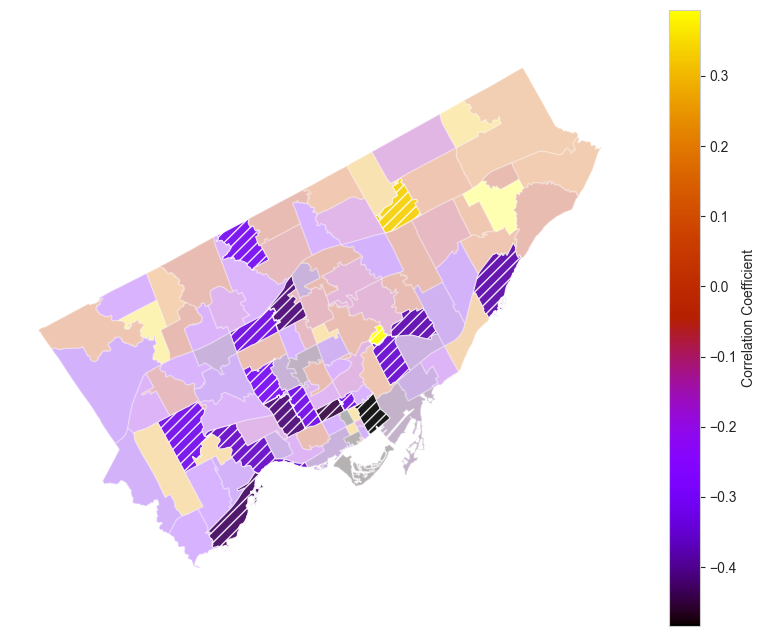

In [88]:
FSA_stats_map['significant'] = FSA_stats_map['p_value'] < 0.05

fig, ax = plt.subplots(figsize=(10, 8))

# Make a layer for FSA's with a significant p-value that includes cross-hatching and is better coloured
FSA_stats_map[FSA_stats_map['significant']].plot(
    column='correlation',
    legend=True,
    legend_kwds={'label':'Correlation Coefficient'},
    ax=ax,
    cmap='gnuplot',
    alpha=0.9,
    hatch='///',
)
# Make a layer for non-significant FSA's with lower alpha
FSA_stats_map[~FSA_stats_map['significant']].plot(
    column='correlation',
    ax=ax,
    cmap='gnuplot',
    alpha=0.3
)
ax.set_axis_off()

Some patterns are there to discuss in the paper, but ultimately I don't think there's much that's worth digging into other than going into a different paper on the demographic patterns to see if there's a layer, but out of scope.

In [89]:
# Make a new column that sums all the "bad" indicators for covid cases
weekly_data['Serious Case Indicators per 1000'] = weekly_data[['Ever in ICU per 1000', 'Ever Intubated per 1000', 'Ever Hospitalized per 1000']].sum(axis=1)

In [130]:
# Remove any rows where there aren't any serious cases or > 10 EMS calls to make sure there's something to work with.

filtered_weekly_data = weekly_data[(weekly_data['Serious Case Indicators per 1000'] > 0) & (weekly_data['EMS Calls'] > 10)].copy()

In [131]:
filtered_weekly_data.head()

Ever Hospitalized  Ever in ICU  Ever Intubated  Weekly Cases  \
Week Start FSA                                                                 
2020-01-26 M2N                  1            0               0             2   
2020-02-23 M2N                  1            0               0             1   
2020-03-01 M6A                  1            1               1             1   
2020-03-08 M1B                  1            1               1             1   
           M1E                  1            0               0             1   

                Weekly Cases per 1000  Ever Hospitalized per 1000  \
Week Start FSA                                                      
2020-01-26 M2N               0.026631                    0.013316   
2020-02-23 M2N               0.013316                    0.013316   
2020-03-01 M6A               0.044683                    0.044683   
2020-03-08 M1B               0.015254                    0.015254   
           M1E               0.020819                    0.020819   

                Ever in ICU per 1000  Ever Intubated per 1000  EMS Calls  \
Week Start FSA                                                             
2020-01-26 M2N              0.000000                 0.000000         79   
2020-02-23 M2N              0.000000                 0.000000         93   
2020-03-01 M6A              0.044683                 0.044683         65   
2020-03-08 M1B              0.015254                 0.015254         95   
           M1E              0.000000                 0.000000         89   

                Priority_Name_High  ...   PRNAME  LANDAREA  \
Week Start FSA                      ...                      
2020-01-26 M2N                  39  ...  Ontario    9.5924   
2020-02-23 M2N                  50  ...  Ontario    9.5924   
2020-03-01 M6A                  28  ...  Ontario    5.5599   
2020-03-08 M1B                  48  ...  Ontario   35.3539   
           M1E                  41  ...  Ontario   15.8104   

                                                         geometry  \
Week Start FSA                                                      
2020-01-26 M2N  POLYGON ((7221634.897 942015.574, 7221671.577 ...   
2020-02-23 M2N  POLYGON ((7221634.897 942015.574, 7221671.577 ...   
2020-03-01 M6A  POLYGON ((7218978.851 936921.534, 7218984.82 9...   
2020-03-08 M1B  POLYGON ((7238905.477 952236.209, 7239316.163 ...   
           M1E  MULTIPOLYGON (((7239497.386 946350.946, 723952...   

                Weekly Cases per 1000 Lag +1 Weekly Cases per 1000 Lag -1  \
Week Start FSA                                                              
2020-01-26 M2N                           NaN                     0.102554   
2020-02-23 M2N                      0.019675                     0.065377   
2020-03-01 M6A                      0.016691                     0.023747   
2020-03-08 M1B                      0.041246                     0.028057   
           M1E                      0.028057                     0.041729   

               Serious Case Indicators per 1000  \
Week Start FSA                                    
2020-01-26 M2N                         0.013316   
2020-02-23 M2N                         0.013316   
2020-03-01 M6A                         0.134048   
2020-03-08 M1B                         0.045763   
           M1E                         0.020819   

               Weekly Cases per 1000 % change  \
Week Start FSA                                  
2020-01-26 M2N                            NaN   
2020-02-23 M2N                     -32.323569   
2020-03-01 M6A                     167.703307   
2020-03-08 M1B                     -63.015788   
           M1E                     -25.796848   

               Weekly EMS Calls per 1000 % change  \
Week Start FSA                                      
2020-01-26 M2N                                NaN   
2020-02-23 M2N                          49.854955   
2020-03-01 M6A                          41.469227   
2020-03-08 M

In [132]:
filtered_weekly_data.shape

(1736, 27)

<Axes: xlabel='% of calls are High Acuity', ylabel='Serious Case Indicators per 1000'>

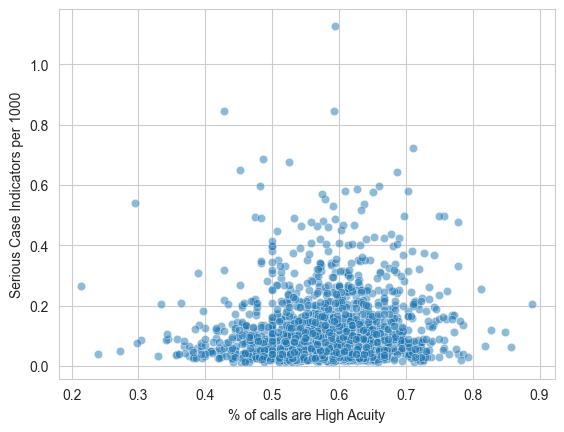

In [133]:
# Graph it to see what there is to see.

sns.scatterplot(filtered_weekly_data, x = '% of calls are High Acuity', y = 'Serious Case Indicators per 1000', alpha = 0.5)

In [134]:
# Make the lags in either direction

filtered_weekly_data.loc[:, 'Serious Case Indicators per 1000 Lag +1'] = filtered_weekly_data['Serious Case Indicators per 1000'].shift(1)
filtered_weekly_data.loc[:, 'Serious Case Indicators per 1000 Lag -1'] = filtered_weekly_data['Serious Case Indicators per 1000'].shift(-1)

In [135]:
def calculate_weekly_high_acuity_stats(group):
    cases = group['Serious Case Indicators per 1000']
    ems_calls = group['Weekly EMS Calls per 1000']

    if len(cases) < 3:
        return pd.Series({'correlation': np.nan, 'p_value': np.nan})

    corr, p_val = pearsonr(cases, ems_calls)
    return pd.Series({'correlation': corr, 'p_value': p_val})

weekly_high_acuity_stats = filtered_weekly_data.groupby('Week Start').apply(calculate_weekly_high_acuity_stats)

weekly_high_acuity_stats.sort_values(by = 'p_value', ascending = True, inplace = True)

weekly_high_acuity_stats

,correlation,p_value
Week Start,,
2020-12-27,0.384213,0.000791
2020-04-19,0.412653,0.000950
2020-05-03,0.354117,0.003533
2020-09-06,0.662427,0.003762
2020-10-25,0.397633,0.005131
2020-04-12,0.340481,0.005906
2020-09-20,0.482023,0.008100
2020-04-26,0.330797,0.011204
2020-12-20,0.243213,0.044039


Well, we got a few more weeks that were significant but all showed no correlation. Let's quickly look at the leads and lags and then move on.

In [137]:
def calculate_weekly_high_acuity_stats_plus_one(group):
    cases = group['Serious Case Indicators per 1000 Lag +1']
    ems_calls = group['Weekly EMS Calls per 1000']

    if len(cases) < 3:
        return pd.Series({'correlation': np.nan, 'p_value': np.nan})

    corr, p_val = pearsonr(cases, ems_calls)
    return pd.Series({'correlation': corr, 'p_value': p_val})

weekly_high_acuity_stats_plus_one = filtered_weekly_data.groupby('Week Start').apply(calculate_weekly_high_acuity_stats_plus_one)

weekly_high_acuity_stats_plus_one.sort_values(by = 'p_value', ascending = True, inplace = True)

weekly_stats_plus_one

,correlation,p_value
Week Start,,
2020-03-22,0.259238,0.012099
2020-09-13,0.212234,0.043418
2020-09-27,0.170444,0.096854
2020-09-20,0.157569,0.131445
2020-03-15,0.168763,0.134534
2020-06-28,-0.169687,0.151225
2020-12-13,-0.133154,0.195901
2020-03-08,-0.194424,0.205999
2020-11-22,-0.128072,0.216138


Two significant weeks, both with weak coefficients

In [138]:
def calculate_weekly_high_acuity_stats_minus_one(group):
    cases = group['Serious Case Indicators per 1000 Lag +1']
    ems_calls = group['Weekly EMS Calls per 1000']

    if len(cases) < 3:
        return pd.Series({'correlation': np.nan, 'p_value': np.nan})

    corr, p_val = pearsonr(cases, ems_calls)
    return pd.Series({'correlation': corr, 'p_value': p_val})

weekly_high_acuity_stats_minus_one = filtered_weekly_data.groupby('Week Start').apply(calculate_weekly_high_acuity_stats_plus_one)

weekly_high_acuity_stats_minus_one.sort_values(by = 'p_value', ascending = True, inplace = True)

weekly_stats_minus_one

,correlation,p_value
Week Start,,
2020-03-22,0.259238,0.012099
2020-09-13,0.212234,0.043418
2020-09-27,0.170444,0.096854
2020-09-20,0.157569,0.131445
2020-03-15,0.168763,0.134534
2020-06-28,-0.169687,0.151225
2020-12-13,-0.133154,0.195901
2020-03-08,-0.194424,0.205999
2020-11-22,-0.128072,0.216138


Two significant weeks, both with weak coefficients

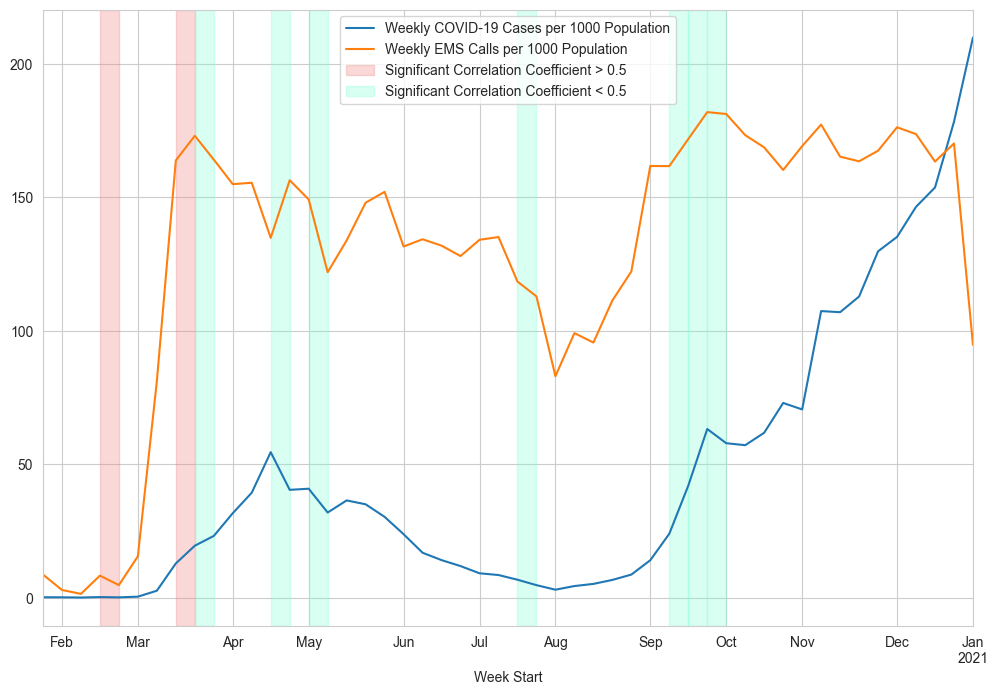

In [103]:
ax = weekly_data.reset_index().groupby('Week Start').agg({
    'Weekly Cases per 1000': 'sum',
    'Weekly EMS Calls per 1000': 'sum'
}).rename(columns={
    'Weekly Cases per 1000': 'Weekly COVID-19 Cases per 1000 Population',
    'Weekly EMS Calls per 1000': 'Weekly EMS Calls per 1000 Population'
}).plot(subplots=False, figsize=(12,8))

significant_greater_than_weeks = [
    '2020-02-16',
    '2020-03-15',
]

for week in significant_greater_than_weeks:
    start_date = pd.to_datetime(week)
    end_date = start_date + pd.Timedelta(days=7)
    ax.axvspan(start_date, end_date, alpha=0.3, color='lightcoral',
               label='Significant Correlation Coefficient > 0.5' if week == significant_greater_than_weeks[0] else "")

significant_less_than_weeks = [
    '2020-09-13',
    '2020-03-22',
    '2020-09-20',
    '2020-09-27',
    '2020-05-03',
    '2020-04-19',
    '2020-07-19',
]

for week in significant_less_than_weeks:
    start_date = pd.to_datetime(week)
    end_date = start_date + pd.Timedelta(days=7)
    ax.axvspan(start_date, end_date, alpha=0.3, color='aquamarine',
               label='Significant Correlation Coefficient < 0.5' if week == significant_less_than_weeks[0] else "")

plt.legend()
plt.show()

Maybe we look at the rate of change - see if there's a relationship there since the significant weeks all seem to be when there's change.

In [139]:
def calculate_weekly_change(df, value_cols):

# Function to take a DF and a list of columns in the DF. Checks if it was given a list, then measures the change relative to the week previous and adds it to a df with the values stored.

    df = df.sort_index()

    if isinstance(value_cols, str):
        value_cols = [value_cols]

    for value_col in value_cols:
        prev_week_value = df[value_col].shift(1)
        df[f'{value_col} % change'] = ((df[value_col] - prev_week_value) / prev_week_value) * 100

    return df

In [140]:
weekly_data = calculate_weekly_change(weekly_data, ['Weekly Cases per 1000', 'Weekly EMS Calls per 1000'])

In [141]:
def calculate_weekly_change_rate_stats(group):
    cases = group['Weekly Cases per 1000 % change']
    ems_calls = group['Weekly EMS Calls per 1000 % change']

    if len(cases) < 3:
        return pd.Series({
            'correlation': np.nan,
            'p_value': np.nan,
            'cases_values': cases.mean(),
            'ems_calls_values': ems_calls.mean()
        })

    corr, p_val = pearsonr(cases, ems_calls)
    return pd.Series({
        'correlation': corr,
        'p_value': p_val,
        'cases_values': cases.mean(),
        'ems_calls_values': ems_calls.mean()
    })

weekly_change_rate_stats = weekly_data.groupby('Week Start').apply(calculate_weekly_change_rate_stats)

weekly_change_rate_stats.sort_values(by = 'p_value', ascending = True, inplace = True)

weekly_change_rate_stats

,correlation,p_value,cases_values,ems_calls_values
Week Start,,,,
2020-10-25,0.434831,0.000013,56.826502,8.512706
2020-04-26,0.425778,0.000026,84.312315,10.256674
2020-11-22,0.308943,0.002317,46.570215,11.999148
2020-03-29,0.306683,0.002945,61.545575,7.694242
2020-03-22,0.289269,0.004919,40.903268,9.956078
2020-12-06,0.279035,0.005904,40.168798,10.863043
2020-02-16,0.988500,0.011500,56.487004,23.477239
2020-09-27,0.237346,0.019890,36.639286,7.456429
2020-05-17,0.232276,0.035740,85.610197,7.720682


Very few significant weeks and all weak correlations.

In [108]:
# Make the leads/lags in either direction

weekly_data['Weekly Cases per 1000 % change Lag +1'] = weekly_data['Weekly Cases per 1000 % change'].shift(1)
weekly_data['Weekly Cases per 1000 % change Lag -1'] = weekly_data['Weekly Cases per 1000 % change'].shift(-1)

In [142]:
def calculate_weekly_change_rate_stats_minus_one(group):
    cases = group['Weekly Cases per 1000 % change Lag -1']
    ems_calls = group['Weekly EMS Calls per 1000 % change']

    if len(cases) < 3:
        return pd.Series({
            'correlation': np.nan,
            'p_value': np.nan,
            'cases_values': cases.mean(),
            'ems_calls_values': ems_calls.mean()
        })

    corr, p_val = pearsonr(cases, ems_calls)
    return pd.Series({
        'correlation': corr,
        'p_value': p_val,
        'cases_values': cases.mean(),
        'ems_calls_values': ems_calls.mean()
    })

weekly_change_stats_minus_one = weekly_data.groupby('Week Start').apply(calculate_weekly_change_rate_stats_minus_one)

weekly_change_stats_minus_one.sort_values(by = 'p_value', ascending = True, inplace = True)

weekly_change_stats_minus_one

,correlation,p_value,cases_values,ems_calls_values
Week Start,,,,
2020-09-06,0.288752,0.009857,45.076089,9.370819
2020-03-29,-0.259453,0.012508,59.976409,7.694242
2020-11-22,-0.228619,0.025853,46.504860,11.999148
2020-04-26,-0.195466,0.063340,84.418784,10.256674
2020-12-13,-0.182745,0.074731,37.203574,9.200992
2020-12-20,0.168109,0.103432,47.190371,12.149250
2020-05-17,-0.167225,0.133190,85.583506,7.720682
2020-03-22,-0.146741,0.160441,39.655032,9.956078
2020-07-12,0.165948,0.166637,54.754278,7.783261


Very little - almost random noise.

In [143]:
def calculate_weekly_change_rate_stats_plus_one(group):
    cases = group['Weekly Cases per 1000 % change Lag +1']
    ems_calls = group['Weekly EMS Calls per 1000 % change']

    if len(cases) < 3:
        return pd.Series({
            'correlation': np.nan,
            'p_value': np.nan,
            'cases_values': cases.mean(),
            'ems_calls_values': ems_calls.mean()
        })

    corr, p_val = pearsonr(cases, ems_calls)
    return pd.Series({
        'correlation': corr,
        'p_value': p_val,
        'cases_values': cases.mean(),
        'ems_calls_values': ems_calls.mean()
    })

weekly_change_stats_plus_one = weekly_data.groupby('Week Start').apply(calculate_weekly_change_rate_stats_plus_one)

weekly_change_stats_plus_one.sort_values(by = 'p_value', ascending = True, inplace = True)

weekly_change_stats_plus_one

,correlation,p_value,cases_values,ems_calls_values
Week Start,,,,
2020-04-26,-0.369787,0.000309,84.901996,10.256674
2020-06-28,-0.218621,0.063140,96.291084,8.367859
2020-03-29,-0.189931,0.069771,61.226761,7.694242
2020-03-22,-0.183500,0.078296,42.741209,9.956078
2020-08-09,-0.223103,0.098372,54.211372,8.843128
2020-06-14,-0.178282,0.118367,110.125949,7.461220
2020-10-25,-0.162114,0.120539,56.749436,8.512706
2020-11-01,-0.152202,0.143071,59.287567,11.403402
2020-05-03,-0.155519,0.143282,72.192996,11.704132


And again, nothing there to see.

In [148]:
# Last thing - try a 3-week smoothing window.

def calculate_smoothed_weekly_change_rate_stats(group, window=3):

    # Apply 3-week rolling average to smooth the data
    cases_smoothed = group['Weekly Cases per 1000'].rolling(window=window, center=False).mean()
    ems_calls_smoothed = group['Weekly EMS Calls per 1000'].rolling(window=window, center=False).mean()

    # Calculate percentage change on smoothed data
    cases_change = ((cases_smoothed - cases_smoothed.shift(1)) / cases_smoothed.shift(1)) * 100
    ems_calls_change = ((ems_calls_smoothed - ems_calls_smoothed.shift(1)) / ems_calls_smoothed.shift(1)) * 100

    # Remove NaN values that result from rolling and shift operations
    valid_mask = ~(cases_change.isna() | ems_calls_change.isna())
    cases_change_clean = cases_change[valid_mask]
    ems_calls_change_clean = ems_calls_change[valid_mask]

    if len(cases_change_clean) < 3:
        return pd.Series({
            'correlation': np.nan,
            'p_value': np.nan,
            'cases_values': np.nan,
            'ems_calls_values': np.nan,
            'n_observations': len(cases_change_clean)
        })

    corr, p_val = pearsonr(cases_change_clean, ems_calls_change_clean)
    return pd.Series({
        'correlation': corr,
        'p_value': p_val,
        'cases_values': cases_change_clean.mean(),
        'ems_calls_values': ems_calls_change_clean.mean(),
        'n_observations': len(cases_change_clean)
    })

smoothed_weekly_change_rate_stats = weekly_data.groupby('Week Start').apply(calculate_smoothed_weekly_change_rate_stats)

smoothed_weekly_change_rate_stats.sort_values(by='p_value', ascending=True, inplace=True)

smoothed_weekly_change_rate_stats

,correlation,p_value,cases_values,ems_calls_values,n_observations
Week Start,,,,,
2020-09-27,0.305716,0.002882,4.001661,1.404876,93.0
2020-04-12,0.297969,0.004123,10.176703,2.043499,91.0
2020-05-10,0.322708,0.005044,15.070966,1.909015,74.0
2020-04-26,0.293588,0.005500,11.951224,2.168422,88.0
2020-10-04,0.286683,0.005596,4.122879,1.472854,92.0
2020-09-06,0.297484,0.009060,6.948765,1.959573,76.0
2020-09-13,0.275087,0.009489,6.335881,1.645107,88.0
2020-06-21,0.285615,0.015759,15.035950,1.214772,71.0
2020-04-19,0.258850,0.016754,17.954728,2.227266,85.0
